In [3]:
"""Download resized imagenet to 8x8, 16x16, 32x32 and 64x64.
This is not to be confused with `downsampled_imagenet` which is a unsupervised
dataset used for generative modeling.
https://github.com/tensorflow/datasets/tree/master/tensorflow_datasets/datasets/imagenet_resized
"""

import io
import itertools
import numpy as np


_LABELS_FNAME = 'image_classification/imagenet_resized_labels.txt'
_URL_PREFIX = 'http://www.image-net.org/data/downsample/'
homepage='https://patrykchrabaszcz.github.io/Imagenet32/'

def download(urls:list):
    for url in urls:
        # download the file from url
        !wget $url


def download_resize_imagenet(size:int):
    assert size in [8, 16, 32, 64], 'Size not implemented!'

    if size in [8, 16, 32]:
        download([
            '%s/Imagenet%d_train_npz.zip' % (_URL_PREFIX, size),
            '%s/Imagenet%d_val_npz.zip' % (_URL_PREFIX, size),
        ])
    elif size == 64:
        # 64x64 uses more than one file due to its size.
       download([
            f'{_URL_PREFIX}/Imagenet64_train_part1_npz.zip',
            f'{_URL_PREFIX}/Imagenet64_train_part2_npz.zip',
            f'{_URL_PREFIX}/Imagenet64_val_npz.zip',
        ])



#download_resize_imagenet(8)
download_resize_imagenet(16)
download_resize_imagenet(32)
download_resize_imagenet(64)


--2023-03-14 16:28:09--  http://www.image-net.org/data/downsample//Imagenet16_train_npz.zip
Resolving www.image-net.org (www.image-net.org)... 171.64.68.16
Connecting to www.image-net.org (www.image-net.org)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://image-net.org/data/downsample/Imagenet16_train_npz.zip [following]
--2023-03-14 16:28:13--  https://image-net.org/data/downsample/Imagenet16_train_npz.zip
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 931837742 (889M) [application/zip]
Saving to: ‘Imagenet16_train_npz.zip’

Imagenet16_train_np 100%[===================>] 888.67M  4.81MB/s    in 8m 33s  

2023-03-14 16:36:49 (1.73 MB/s) - ‘Imagenet16_train_npz.zip’ saved [931837742/931837742]

--2023-03-14 16:36:50--  http://www.image-net.org/data/downsample//Imagenet16_val_npz.zip
Reso

In [ ]:
# unzip the all the present zip files
!unzip -q '*.zip'

In [1]:
from pathlib import Path
from pprint import pprint

path = Path()
folders = [p for p in path.glob('*') if p.is_dir()]
folders

out = {}
for folder in folders:
    meta = folder.name.split('_')
    size = int(meta[0].replace('Imagenet', ''))
    split = meta[1]

    if size not in out:
        out[size] = {}
    if split not in out[size]:
        out[size][split] = {}

    files = list(folder.glob("*.npz"))
    for file in files:
        part = file.stem.split('_')[-1]
        part = int(part) if part.isdigit() else 1
        out[size][split][part] = file ##file.stat().st_size
    
pprint(out)


{8: {'train': {1: PosixPath('Imagenet8_train_npz/train_data_batch_1.npz'),
               2: PosixPath('Imagenet8_train_npz/train_data_batch_2.npz'),
               3: PosixPath('Imagenet8_train_npz/train_data_batch_3.npz'),
               4: PosixPath('Imagenet8_train_npz/train_data_batch_4.npz'),
               5: PosixPath('Imagenet8_train_npz/train_data_batch_5.npz'),
               6: PosixPath('Imagenet8_train_npz/train_data_batch_6.npz'),
               7: PosixPath('Imagenet8_train_npz/train_data_batch_7.npz'),
               8: PosixPath('Imagenet8_train_npz/train_data_batch_8.npz'),
               9: PosixPath('Imagenet8_train_npz/train_data_batch_9.npz'),
               10: PosixPath('Imagenet8_train_npz/train_data_batch_10.npz')},
     'val': {1: PosixPath('Imagenet8_val_npz/val_data.npz')}},
 16: {'train': {1: PosixPath('Imagenet16_train_npz/train_data_batch_1.npz'),
                2: PosixPath('Imagenet16_train_npz/train_data_batch_2.npz'),
                3: PosixPath('

In [3]:
from PIL import Image
import numpy as np

P = Path('data')
P.mkdir(exist_ok=True)

out2 = {}
for size in sorted(out):
    print(size)
    for fold in out[size]:
        arr_image = [None] * len(out[size][fold])
        arr_label = [None] * len(out[size][fold])
        #arr_mean = [None] * len(out[size][fold])
        for part, part_file in out[size][fold].items():
            a = np.load(part_file)
            a_dict = {k: a[k] for k in a.files}
            for k in a_dict:
                if k == 'data':
                    a_dict[k]=a_dict[k].reshape(-1, 3, size, size)
                    #a_dict[k] = a_dict[k].transpose(0, 2, 3, 1)
                    arr_image[part-1] = a_dict[k]
                elif k == 'mean':
                    a_dict[k] = a_dict[k].reshape(3, size, size)
                    #a_dict[k] = a_dict[k].transpose(0, 2, 3, 1)
                elif k == 'labels':
                    arr_label[part-1] = a_dict[k]
                
                    #print(k, a_dict[k].shape)
                    #display first image Pillow
                    #print(a_dict[k][0].shape, a_dict[k][0].dtype)
                    #img = Image.fromarray(a_dict[k][0])
                    #display(img)
                #print(k, a_dict[k].shape)

        arr_image = np.concatenate(arr_image, axis=0)
        arr_label = np.concatenate(arr_label, axis=0)
        
        fn_image = f'{size}_{fold}.npz'
        fn_label = f'{size}_{fold}_labels.npy'

        np.save(str(P / fn_image), arr_image)
        np.save(str(P / fn_label), arr_label)

        #out2[fn_image] = arr_image
        #out2[fn_label] = arr_label

        del arr_image
        del arr_label
   
#for fn, arr in out2.items():
#    print(fn, arr.shape)

        

8
16
32
64


In [ ]:
#create a folder "data" and move all the npz files there from out2

for fn, arr in out2.items():
    p = P/fn
    

In [3]:
import numpy as np
import torch


x_val = np.load("data/64_val.npy")
y_val = np.load("data/64_val_labels.npy")
print('x_val', x_val.shape)
print('y_val', y_val.shape, y_val.min(), y_val.max())

x_val (50000, 3, 64, 64)
y_val (50000,) 1 1000


In [39]:
import torch
from torch.utils.data import TensorDataset
from pathlib import Path
import numpy as np


class ImageNetResized(TensorDataset):
    """ImageNetResized dataset."""
    NUM_CLASSES = 1000

    def __init__(self, root:str, *args, size:int=8, train:bool=False, **kwargs):
        self.root = Path(root)
        self.size = size
        assert size in [8, 16, 32, 64], f'Size not implemented: {size}'
        self.train = train
        self.split: str = 'train' if train else 'val'
        x_path = self.root / f'{size}_{self.split}.npy'
        y_path = self.root / f'{size}_{self.split}_labels.pt'
        x = np.load(x_path)
        y = torch.load(y_path)
        super().__init__(torch.from_numpy(x), y, *args, **kwargs)

    
ds8train = ImageNetResized('data', size=8, train=True)
len(ds8train), ds8train[0][0].shape, ds8train[0][1]

ds32val = ImageNetResized('data', size=32, train=True)
len(ds32val), ds32val[0][0].shape, ds32val[0][1]



(1281167, torch.Size([3, 32, 32]), tensor(933))

torch.Size([64, 3, 32, 32]) torch.Size([64])


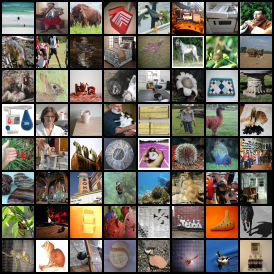

In [20]:
from torchvision.utils import make_grid
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

indexs = np.random.randint(0, len(ds32val), 64)
samples = [ds32val[i] for i in indexs]
images = torch.stack([s[0] for s in samples])
labels = torch.stack([s[1] for s in samples])
print(images.shape, labels.shape)

im = make_grid(images.detach(), nrow=8)
display(Image.fromarray(im.permute(1, 2, 0).numpy()))







In [22]:
!wget https://raw.githubusercontent.com/tensorflow/datasets/master/tensorflow_datasets/image_classification/imagenet_resized_labels.txt

--2023-03-15 11:32:05--  https://raw.githubusercontent.com/tensorflow/datasets/master/tensorflow_datasets/image_classification/imagenet_resized_labels.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10000 (9.8K) [text/plain]
Saving to: ‘imagenet_resized_labels.txt’

imagenet_resized_la 100%[===================>]   9.77K  --.-KB/s    in 0.001s  

2023-03-15 11:32:08 (13.5 MB/s) - ‘imagenet_resized_labels.txt’ saved [10000/10000]



convert unofficial labels to official imagenet labels

In [40]:
import json 

meta_p = "/mnt/DSDIR/ImageNet32x32/scripts/official/imagenet_synset.json"
with open(meta_p) as f:
    meta = json.load(f)

# create a dict of key "unofficial" label to "official" label
conv = {}
for k, v in meta.items():
    conv[v['index_unoff']] = v['index']
#print(conv)

path = Path('data') 
files = list(path.glob("*_labels.npy"))

for file in files:
    print(file)
    labels = np.load(file)
    print(labels.shape, labels.min(), labels.max())
    labels_conv = np.array([conv[l] for l in labels-1])
    # save the new labels to torch 
    torch.save(torch.from_numpy(labels_conv), file.with_suffix('.pt'))


data/16_train_labels.npy
(1281167,) 1 1000
data/16_val_labels.npy
(50000,) 1 1000
data/32_train_labels.npy
(1281167,) 1 1000
data/32_val_labels.npy
(50000,) 1 1000
data/64_train_labels.npy
(1281167,) 1 1000
data/64_val_labels.npy
(50000,) 1 1000
data/8_train_labels.npy
(1281167,) 1 1000
data/8_val_labels.npy
(50000,) 1 1000


In [42]:
path = Path('data') 
# find all file that does NOT match the pattern "*_labels.npy"
files = list(path.glob("*.npy"))
files = [f for f in files if not f.name.endswith('_labels.npy')]
print(files)

for file in files:
    # convert it to torch
    data = np.load(file)
    torch.save(torch.from_numpy(data), file.with_suffix('.pt'))


[PosixPath('data/16_train.npy'), PosixPath('data/16_val.npy'), PosixPath('data/32_train.npy'), PosixPath('data/32_val.npy'), PosixPath('data/64_train.npy'), PosixPath('data/64_val.npy'), PosixPath('data/8_train.npy'), PosixPath('data/8_val.npy')]


In [ ]:
# remove all the .npy files
files = list(path.glob("*.npy"))
for file in files:
    file.unlink()
